In [349]:
import numpy as np
import pybullet as p
from PybulletCore import pybullet_core
import time
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Open Pybullet GUI

In [350]:
pb = pybullet_core()
pb.connect_pybullet(robot_name = "IndyRP2", joint_limit=True)

****** LOAD SUCCESS ******
Robot name: IndyRP2
DOF: 7
Joint limit: True


In [ ]:
pb.disconnect_pybullet()

# 2. Move Robot

## Random Move

In [33]:
pb.MoveRobotByJointAngle(2*(1-2*np.random.rand(pb.numJoint)), verbose=True)

Set desired joint angle: [ 0.25437784 -0.96696793 -1.27094302  1.07210202  0.2975588   1.88931366
  1.98512427]


In [326]:
pb.disconnect_pybullet()

Exception in thread Thread-18:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\MECH639\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\user\anaconda3\envs\MECH639\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "d:\MECH639\mech639_pybullet\PybulletCore.py", line 214, in _SetRobotJoint
    p.setJointMotorControlArray(bodyUniqueId=self.robotId,
NameError: name 'p' is not defined


Disconnect Success!


## Null Motion

In [ ]:
Ts = np.array([
    [ 1, 0, 0,  0.1],
    [ 0, 1, 0,  0.1],
    [ 0, 0, 1,  1],
    [ 0, 0, 0,  1]])

pb.MoveRobotByPoseNull(Ts,mag=5,N=20)

## Move point to point

In [ ]:
pb.RemoveTraces()
Ts = np.array([
    [ 1, 0, 0,  0],
    [ 0, 1, 0,  0.1],
    [ 0, 0, 1,  0.8],
    [ 0, 0, 0,  1]])
Te = np.array([
    [ 1, 0, 0,  0],
    [ 0, 1, 0,  -0.2],
    [ 0, 0, 1,  0.8],
    [ 0, 0, 0,  1]])

pb.MoveRobotByPose(Ts, verbose=True, maxiter=10)
time.sleep(1)

a = time.time()
pb.MoveRobotPoint2Point(Ts, Te, 0.1,trace=False)
print(time.time()-a)
time.sleep(1)
pb.endEffectorPosition

## Inverse Kinetamics

In [304]:
Ts = np.array([
    [ 0, 0, -1,  0.2],
    [ 0, 1, 0,  0.4],
    [ 1, 0, 0,  0.8],
    [ 0, 0, 0,  1]])
pb.MoveRobotByPoseMaxManip(Ts,miniter=100,eomg=0.001)
time.sleep(3)
print(Ts[0:3,3])
print(pb.endEffectorPosition)

mu update: 0.09221831541778618
mu update: 0.14056845261421524
mu update: 0.15119194853025497
[0.2 0.4 0.8]
[0.13500402 0.39999683 0.73499965]


## Create Trajectory and Tracking

In [376]:
pb.RemoveObjects(N=100)
traj = pb.CreateArbitaryCirclePath(10,0.022)

[Remove Objects] :  90%|█████████ | 90/100 [00:02<00:00, 43.50it/s]


In [378]:
pb.RemoveTraces()
his = pb.MoveRobotTrajactory(traj,trace=True,verbose=True,jointLimit=False,initMaxMani=True,Nfit=0)

[Remove Traces] : 100%|██████████| 455/455 [00:07<00:00, 60.08it/s]


mu update: 0.08852902758186681
mu update: 0.09936124692913682
mu update: 0.1040048594681876
mu update: 0.12588790413194068
mu update: 0.13250500141054486
Tracking Time: 9.928921699523926


In [285]:
pb.RemoveTraces()
pb.RemoveObjects(N=100)

[Remove Objects] :  90%|█████████ | 90/100 [00:02<00:00, 42.26it/s]


# 3. Plot

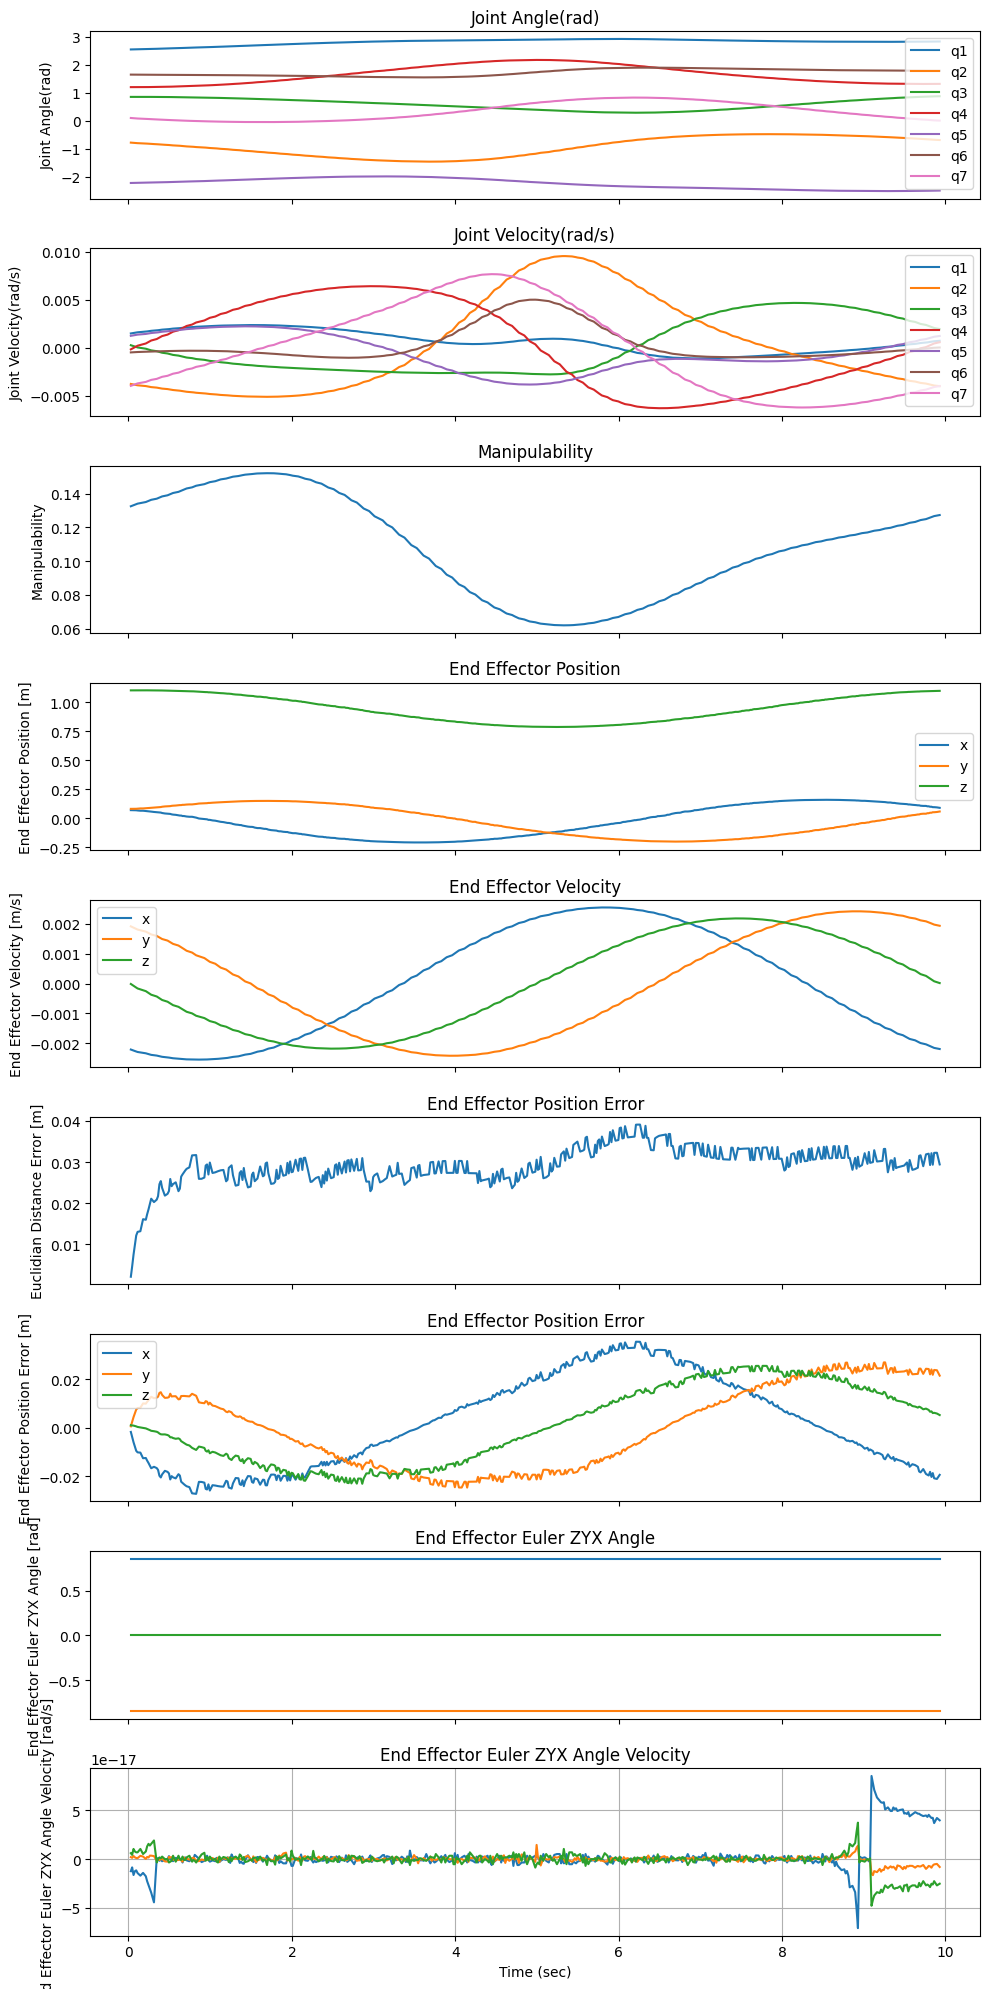

In [379]:
from RoboticsCore import *

N = len(his["des_traj"])
pos_rms_error = []
pos_error = []
mu = []
eulerZYX = []
eulerZYX_dot = []
for i in range(N):
    pos_rms_error.append(np.linalg.norm(his["des_traj"][i][0:3,3]-his["real_traj"][i][0:3,3]))
    pos_error.append(his["des_traj"][i][0:3,3]-his["real_traj"][i][0:3,3])
    mu.append(np.sqrt(np.linalg.det(np.dot(his["jacobian"][i],his["jacobian"][i].T))))
    r1,r2=RotToEulerZYZ(his["des_traj"][i][0:3,0:3])
    eulerZYX.append(r1)
    phi = r1[0]
    theta = r1[1]
    Tr = np.array([
        [0,-np.sin(phi),np.cos(phi)*np.sin(theta)],
        [0,np.cos(phi),np.sin(phi)*np.sin(theta)],
        [1,0,np.cos(theta)]])
    repT = np.r_[np.c_[np.eye(3),np.zeros((3,3))],np.c_[np.zeros((3,3)),Tr]]
    Jr = np.dot(np.dot(np.linalg.pinv(repT),his["jacobian"][i]),his["joint_velocity"][i])
    eulerZYX_dot.append(Jr[3:6])

plt.figure(figsize=(10,20))

pN=9
ax1 = plt.subplot(pN, 1, 1)
plt.plot(his["time"], his["joint_angle"])
plt.title('Joint Angle(rad)')
plt.ylabel('Joint Angle(rad)')
plt.legend([f"q{x}" for x in range(1,8)])
plt.xticks(visible=False)

ax2 = plt.subplot(pN, 1, 2, sharex=ax1)
plt.plot(his["time"], his["joint_velocity"])
plt.title('Joint Velocity(rad/s)')
plt.ylabel('Joint Velocity(rad/s)')
plt.legend([f"q{x}" for x in range(1,8)])
plt.xticks(visible=False)

ax3 = plt.subplot(pN, 1, 3)
plt.plot(his["time"], mu)
plt.title('Manipulability')
plt.ylabel('Manipulability')
plt.xticks(visible=False)

ax4 = plt.subplot(pN, 1, 4)
plt.plot(his["time"], his["ee_position"])
plt.title('End Effector Position')
plt.ylabel('End Effector Position [m]')
plt.legend(["x","y","z"])
plt.xticks(visible=False)

ax5 = plt.subplot(pN, 1, 5)
plt.plot(his["time"], his["ee_velocity"])
plt.title('End Effector Velocity')
plt.ylabel('End Effector Velocity [m/s]')
plt.legend(["x","y","z"])
plt.xticks(visible=False)

ax6 = plt.subplot(pN, 1, 6)
plt.plot(his["time"], pos_rms_error)
plt.title('End Effector Position Error')
plt.ylabel('Euclidian Distance Error [m]')
plt.xticks(visible=False)

ax7 = plt.subplot(pN, 1, 7)
plt.plot(his["time"], pos_error)
plt.legend(["x","y","z"])
plt.title('End Effector Position Error')
plt.ylabel('End Effector Position Error [m]')
plt.xticks(visible=False)

ax8 = plt.subplot(pN, 1, 8)
plt.plot(his["time"], eulerZYX)
plt.title('End Effector Euler ZYX Angle')
plt.ylabel('End Effector Euler ZYX Angle [rad]')
plt.xticks(visible=False)

ax9 = plt.subplot(pN, 1, 9)
plt.plot(his["time"], eulerZYX_dot)
plt.title('End Effector Euler ZYX Angle Velocity')
plt.ylabel('End Effector Euler ZYX Angle Velocity [rad/s]')

plt.grid(True)
plt.xlabel("Time (sec)")
plt.tight_layout()
plt.show()
    

# ETC

In [ ]:
pb.RemoveObjects(N=100)
pb.RemoveTraces()
his = pb.circlingRobot(5,verbose=True,dt=0.02,jointLimit=False,trace=True)

In [873]:
pb.MoveRobotByJointAngle(2*(1-2*np.random.rand(pb.numJoint)), verbose=True)

Set desired joint angle: [ 0.24135927  0.44366552 -1.39598563 -1.64493509 -1.95887105 -0.85664029
 -0.12721131]


In [1026]:
pb.disconnect_pybullet()

Disconnect Success!


In [161]:
pb.configureDebugMode(False)

In [505]:
pb.RemoveDebugItems()

[Remove Objects] :  94%|█████████▍| 188/200 [00:03<00:00, 53.02it/s]


In [980]:
pb.MoveRobotByVelocityTime(np.array([0,0,0.1,0,0,0]).T,2,frame="world",verbose=True)

Set desired joint angle: [-0.36771209 -0.92090539 -0.77331696  0.78203151 -0.32686397 -1.67279308
  0.35397238]
Measured Last Joint's Position: (0.44291305777438494, -0.28356137107729734, 0.869121733027704)
Set desired joint angle: [-0.36555018 -0.9166665  -0.7744048   0.77540216 -0.32585698 -1.67008233
  0.35342917]
Measured Last Joint's Position: (0.44291305777436785, -0.2835613710773044, 0.8691217330279586)
Set desired joint angle: [-0.36200404 -0.90979371 -0.77621135  0.76460777 -0.32423837 -1.66565718
  0.3525542 ]
Measured Last Joint's Position: (0.4429130586740798, -0.2835613378909083, 0.8692761529970834)
Set desired joint angle: [-0.35929811 -0.9046474  -0.77761634  0.75646914 -0.32304396 -1.66230701
  0.35190567]
Measured Last Joint's Position: (0.4429138386756247, -0.2835608758332262, 0.8696097266011529)
Set desired joint angle: [-0.35747934 -0.90123722 -0.77857345  0.75104825 -0.32226152 -1.66006873
  0.35147902]
Measured Last Joint's Position: (0.4429171348643369, -0.283559

In [819]:
import random
psi = random.random()*(np.pi*2) - np.pi
theta = random.random()*(np.pi*2) - np.pi
phi = random.random()*(np.pi*2) - np.pi
traj = pb.CreateCirclePathFromEulerZYX(phi,theta,psi,[0,0,1],0.2,N=200, maxShape=10)

In [814]:
traj = pb.CreateCirclePathFromVector([0,0,1],[0.1,-0.1,0.1],N=200, maxShape=10)

In [821]:
pb.RemoveObjects(N=500)

[Remove Objects] :  99%|█████████▊| 493/500 [00:09<00:00, 50.09it/s]


# 4. Close Pybullet GUI

In [348]:
pb.disconnect_pybullet()

Exception in thread Thread-20:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\MECH639\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\user\anaconda3\envs\MECH639\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "d:\MECH639\mech639_pybullet\PybulletCore.py", line 214, in _SetRobotJoint
    p.setJointMotorControlArray(bodyUniqueId=self.robotId,
NameError: name 'p' is not defined


Disconnect Success!
